### 0. Imports and setup

In [17]:
from src.dataset import Colored3DMNIST, DataLoader
from torchvision import transforms, datasets
from IPython.display import clear_output
from matplotlib.colors import rgb2hex
from src.nn import UNet, ResNet_D
from src.plot import plot_img
from pathlib import Path
from tqdm import tqdm

import torch.nn.functional as F
import matplotlib.pyplot as plt
import src.data as data
import torch.nn as nn
import numpy as np
import torchvision
import torch
import gc

In [18]:
if torch.cuda.is_available():
    torch.cuda.set_device(f"cuda:0")
torch.manual_seed(42)
np.random.seed(42)

### 1. Getting the data ready

In [25]:
BATCH_SIZE = 32

def random_color(im):
    hue = np.random.choice([60, 120, 240, 280])
    d = (im *(hue%60)/60)
    im_min, im_inc, im_dec = torch.zeros_like(im), d, im - d
    c_im = torch.zeros((3, im.shape[1], im.shape[2]))
    H = round(hue/60) % 6    
    cmap = [[0, 3, 2], [2, 0, 3], [1, 0, 3], [1, 2, 0], [3, 1, 0], [0, 1, 2]]
    return torch.cat((im, im_min, im_dec, im_inc), dim=0)[cmap[H]]

def Add_dimension(im):
    img_3D = torch.zeros(im.shape[0], im.shape[1], im.shape[2], 16)
    for i in range(im.shape[1]):
      if i < 7 or i > 9:
        img_3D[:, :, :, i] = torch.zeros_like(im)
      else:
        img_3D[:, :, :, i] = im
    return img_3D 

TRANSFORM_3D = transforms.Compose([
    transforms.Resize(16),
    transforms.ToTensor(),
    random_color,
    Add_dimension,
])

# Load train datasets
mnist_train_a = datasets.MNIST(root='./data', train=True, download=True, transform=TRANSFORM_3D)

indices = mnist_train_a.targets == 3
mnist_train_a.data, mnist_train_a.targets = mnist_train_a.data[indices], mnist_train_a.targets[indices]

mnist_loader_a = torch.utils.data.DataLoader(mnist_train_a, batch_size=BATCH_SIZE, shuffle=True)


mnist_train_b = datasets.MNIST(root='./data', train=True, download=True, transform=TRANSFORM_3D)

indices = mnist_train_b.targets == 5
mnist_train_b.data, mnist_train_b.targets = mnist_train_b.data[indices], mnist_train_b.targets[indices]

mnist_loader_b = torch.utils.data.DataLoader(mnist_train_b, batch_size=BATCH_SIZE, shuffle=True)


mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=TRANSFORM_3D)

indices = mnist_test.targets == 3
mnist_test.data, mnist_test.targets = mnist_test.data[indices], mnist_test.targets[indices]

mnist_loader_test = torch.utils.data.DataLoader(mnist_test, batch_size=BATCH_SIZE, shuffle=True)

Let's plot a number:

In [26]:
def plot_img(img):
    fig = plt.figure()
    ax = plt.axes(projection="3d")

    color = np.array([rgb2hex(rgb) for rgb in img.numpy().reshape(3, -1).T])
    color = color.reshape(*img.shape[1:])
    
    if torch.any(img[0, ...]):
        img = img[0, ...]
    elif torch.any(img[1, ...]):
        img = img[1, ...]
    else:
        img = img[2, ...]
    
    ax.voxels(img, facecolors=color)
    fig.show()


/tmp/ipykernel_104064/2025946399.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


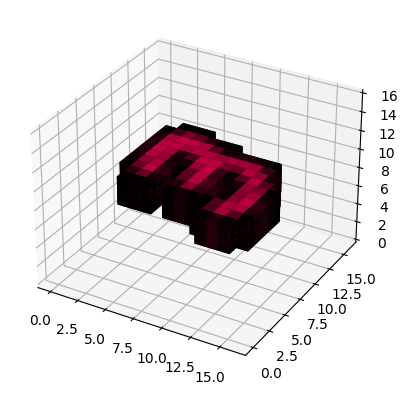

In [30]:
plot_img(next(iter(mnist_train_a))[0])

### 3. Preparation for the training

In [6]:
# Taken from https://github.com/iamalexkorotin/NeuralOptimalTransport/blob/main/src/tools.py
def weights_init_D(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='leaky_relu')
    elif classname.find('BatchNorm') != -1:
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)
        
def weights_init_mlp(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')

In [7]:
f = ResNet_D(16, nc=3).cuda()
f.apply(weights_init_D)

T = UNet(3, 3).cuda()

In [8]:
iter_train_a = iter(mnist_loader_a)
iter_train_b = iter(mnist_loader_b)
iter_test = iter(mnist_loader_test)

def sample_train_a():
    global mnist_loader_a, iter_train_a
    try:
        return next(iter_train_a)[0]
    except StopIteration:
        iter_train_a = iter(mnist_loader_a)
        return next(iter_train_a)[0]

def sample_train_b():
    global mnist_loader_b, iter_train_b
    try:
        return next(iter_train_b)[0]
    except StopIteration:
        iter_train_b = iter(mnist_loader_b)
        return next(iter_train_b)[0]

def sample_test():
    global mnist_loader_test, iter_test
    try:
        return next(iter_test)[0]
    except StopIteration:
        iter_test = iter(mnist_loader_test)
        return next(iter_test)[0]

In [9]:
T_opt = torch.optim.Adam(T.parameters(), lr=1e-4, weight_decay=1e-10)
f_opt = torch.optim.Adam(f.parameters(), lr=1e-4, weight_decay=1e-10)

### 4. Training loop

In [10]:
def sq_cost(X, Y):
  return (X-Y).square().flatten(start_dim=1).mean(dim=1)

In [11]:
for step in tqdm(range(10001)):
    clear_output(wait=True)

    # Training T, freezing f
    T.train(True)
    f.eval()
    
    for i in range(5):
        X = sample_train_a().cuda()

        T_X = T(X)
        T_loss = sq_cost(X, T_X).mean() - f(T_X).mean()
        T_opt.zero_grad()
        T_loss.backward()
        T_opt.step()
    
    print(f"T_loss: {T_loss}; ", end="")

    # Training f, freezing T
    f.train(True)
    T.eval()

    X = sample_train_a().cuda()
    Y = sample_train_b().cuda()

    with torch.no_grad():
        T_x = T(X)
    
    f_loss = f(T_x).mean() - f(Y).mean()
    f_opt.zero_grad()
    f_loss.backward()
    f_opt.step()

    print(f" f_loss: {f_loss}")

    # Save OT map every 1000 steps
    if not step % 1000:
        torch.save(T.state_dict, f"weights/OT_{step}.pt")

    gc.collect()
    torch.cuda.empty_cache()

 68%|██████▊   | 6781/10001 [51:03<24:14,  2.21it/s]

T_loss: 698.7442016601562;  f_loss: 1680.94140625


KeyboardInterrupt: 

In [ ]:
T_1000 = UNet(3, 3).cuda()
